In [1]:
import dream
import powder_reduction
import scipp as sc
from scipp import Dim

# Testing dream class that generates fake powder dataset
<div class="alert alert-block alert-info">
<b>Information:</b> This notebook shows how to use some of `scipp` functionalities related to the "DREAM" powder diffraction reduction workflow.

<b>Requirements:</b> To run this notebook, you need `matplotlib`, `scipp`, `scipy` installed as well as the Python scripts `powder_reduction.py` and `dream.py` placed in the same folder as this notebook.   
</div>

- Uses the `dream` module to create a fake sparse dataset with a given number of pixels and events.

- The dataset includes a calibration file `dream.cal` which is used to convert the resulting signal to d-spacing.

- At the end the resulting data is plotted using `plotly`.

In [6]:
# Script for demonstration of event generation
n_pixel = int(2E4)
n_events = int(2E6)

Dream = dream.DreamTest(n_pixel) # Create a fake dream powder diffractometer with detector positions and calibration data
# Display the detector position DataSet and calibration DataSet 
print("Dataset with pixels initialized")
print(Dream.data)
print("Calibration dataset:")
print(Dream.cal)

Dataset with pixels initialized
<scipp.Dataset>
Dimensions: {{Dim.Tof, 10}, {Dim.Position, 20000}}
Coordinates:
    Dim.Position              vector_3_double  [m]              (Dim.Position)  [(0.323524, 0.000000, 1.207407), (0.323677, 0.000000, 1.207366), ..., (0.427674, 0.000000, -1.174562), (0.427525, 0.000000, -1.174616)]
    Dim.Tof                   double     [μs]            (Dim.Tof)  [0.000000, 1.000000, ..., 8.000000, 9.000000]
Labels:
    component_info            Dataset    [dimensionless]  ()  [Dataset]
Data:
    sample
        Sparse coordinate:
            Dim.Tof           double     [μs]            (Dim.Position, Dim.Tof [sparse])  [[], [], ..., [], []]


Calibration dataset:
<scipp.Dataset>
Dimensions: {{Dim.Position, 20000}}
Data:
    difc                      double     [Å^-1 μs]     (Dim.Position)  [5133.898105, 5136.365414, ..., 38734.342550, 38734.774770]
    tzero                     double     [μs]            (Dim.Position)  [0.000000, 0.000000, ..., 0.000000, 

## Generating a sample
A powder sample with a number of random Bragg peaks are generated. 

Here we create 30 Bragg peaks in the range of 2 to 10 AA with a $\Delta$d over d range between 0.2 and 0.7 %. 

The relative strength of each of these is random as well, varying between 1.0 and 5.0. The sample data will be remembered by the Dream object.

In [11]:
Dream.generate_random_sample(30, d_range=[2, 10], deltad_over_d_range=[0.2, 0.7], strength_range=[1.0, 5.0])

In [12]:
print("Generated bragg peak d spacings") # The data can be accessed directly to check
print(Dream.sample_bragg_peaks_d)

Generated bragg peak d spacings
[2.0908993084788694, 3.2270319157924954, 3.383082543525738, 3.5474870811235233, 3.6968825360336677, 3.7535066806959394, 3.9524097469127604, 4.193417994671564, 4.457685733307049, 4.485022356327031, 4.566523151204191, 4.808796784601345, 4.999918902323248, 5.061915183957282, 5.120139023841308, 5.827846018208414, 5.978762051095401, 6.690201226882448, 7.101221892449216, 7.147855159656507, 7.25470689049795, 7.566772823343637, 7.808206548009387, 8.37409146802397, 8.645588508374273, 8.74058470103471, 9.317135999728972, 9.378895896869128, 9.605447867070701, 9.646919040441318]


## Generating random time of flight data
The fake instrument and sample are now used to generate a requested number of events. 

The wavelength window can be adjusted. 

A simple text based progress bar will be shown unless the keyword argument `verbose` is set to False. 

The resulting data is checked and compared to the ESS timeframe, it would be optimal to have just under 100% coverage.

In [19]:
print("Generating random sparse data")
Dream.generate_data_pseudo(n_events, wavelength_width=3.5, wavelength_center=3.0)

Generating random sparse data
Generating sparse data for each pixel
0%
10%
20%
30%
40%
50%
60%
70%
80%
90%
Data was generated in 4.49 seconds.
Distributed 2001049 events into 20000 pixels.
Minimum time recorded: 24015 us
Maximum time recorded: 95409 us
Corresponding to a frame of: 71394 us, which is 100.0% of the available frame


In [20]:
print(Dream.data) # Print an overview of the resulting dataset

<scipp.Dataset>
Dimensions: {{Dim.Tof, 10}, {Dim.Position, 20000}}
Coordinates:
    Dim.Position              vector_3_double  [m]              (Dim.Position)  [(0.323524, 0.000000, 1.207407), (0.323677, 0.000000, 1.207366), ..., (0.427674, 0.000000, -1.174562), (0.427525, 0.000000, -1.174616)]
    Dim.Tof                   double     [μs]            (Dim.Tof)  [0.000000, 1.000000, ..., 8.000000, 9.000000]
Labels:
    component_info            Dataset    [dimensionless]  ()  [Dataset]
Data:
    sample
        Sparse coordinate:
            Dim.Tof           double     [μs]            (Dim.Position, Dim.Tof [sparse])  [[24766.170968, 24931.668084, ..., 49614.012037, 49722.935778], [24931.965588, 24745.626609, ..., 49525.605157, 49777.255220], ..., [80762.969470, 81136.532442, 81414.498354], [80424.516807, 80383.976197, 80683.074817, 80803.373750]]




## Convert time of flight data to dspacing
The raw time of flight data now needs to be converted back to dspacing. This can be done using the calibration data calculated within the Dream object, or without assuming a perfect instrument. 

The two methods will give the same results in this case.

In [21]:
dspacing = powder_reduction.powder_reduction(Dream.data, calibration=Dream.cal)
print(dspacing) # Show the converted dataset

<scipp.Dataset>
Dimensions: {{Dim.DSpacing, 10}, {Dim.Position, 20000}}
Coordinates:
    Dim.Position              vector_3_double  [m]              (Dim.Position)  [(0.323524, 0.000000, 1.207407), (0.323677, 0.000000, 1.207366), ..., (0.427674, 0.000000, -1.174562), (0.427525, 0.000000, -1.174616)]
    Dim.DSpacing              double     [Å]            (Dim.Position, Dim.DSpacing)  [0.000000, 0.000195, ..., 0.000207, 0.000232]
Labels:
    component_info            Dataset    [dimensionless]  ()  [Dataset]
Data:
    sample
        Sparse coordinate:
            Dim.DSpacing      double     [Å]            (Dim.Position, Dim.DSpacing [sparse])  [[4.824048, 4.856284, ..., 9.664004, 9.685221], [4.854009, 4.817731, ..., 9.642150, 9.691144], ..., [2.085048, 2.094692, 2.101869], [2.076287, 2.075241, 2.082962, 2.086068]]




In [22]:
print(dspacing.dims) # Show the dimensionality of the dspacing dataset

[Dim.Position, Dim.DSpacing]


## Plotting the dspacing dataset
First the raw data is collected from each of the sparse channels in the detector array. Next `numpy` is used to histogram the data, after which the data is plotted with `matplotlib`. We see a diffraction pattern with peaks in the specified interval.

In [23]:
# Extract the sparse dspacing data from the scipp variable
raw_data = []
for i in range(len(dspacing.coords[Dim.Position].values)):
    sparse = dspacing['sample'].coords[Dim.DSpacing][Dim.Position, i].values
    this_data = [sparse[k] for k in range(len(sparse))]
    raw_data.extend(this_data)

{'Dim.DSpacing.Å': {'fill_between': {'data': <matplotlib.collections.PolyCollection at 0x1235befd0>},
  'step': {'data': [<matplotlib.lines.Line2D at 0x1291de2b0>]},
  'line': {},
  'errorbar': {},
  'ax': <matplotlib.axes._subplots.AxesSubplot at 0x12c3067b8>,
  'fig': <Figure size 432x288 with 1 Axes>}}

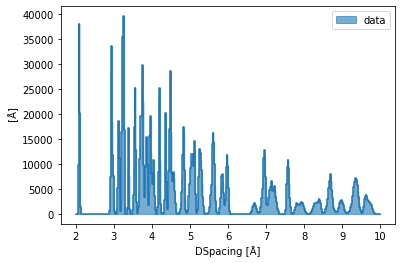

In [24]:
# Plot using scipp feature
import numpy as np
from scipp.plot import plot
%matplotlib inline

data_to_plot = sc.Dataset()
N = 501
bins = np.linspace(2.0, 10.0, N).astype(np.float64)
histogram_data, edges = np.histogram(raw_data, bins)

data_to_plot.coords[Dim.DSpacing] = sc.Variable([Dim.DSpacing], values=bins, unit=sc.units.angstrom)

data_to_plot["data"] = sc.Variable([Dim.DSpacing], values=histogram_data, unit=sc.units.angstrom)

sc.plot.config.backend = "matplotlib"
plot(data_to_plot["data"])